In [1]:
from pathlib import Path

DATA = Path("scrape")
assert DATA.is_dir()

In [2]:
from ipyfilechooser import FileChooser
from ipywidgets import Layout

fc = FileChooser(
    DATA,
    filter_pattern="*.pdf",
    title="Select PDF file to extract",
    layout=Layout(width="100%"),
)
display(fc)

FileChooser(path='/home/max/Documents/Code/BDRAD/Radiology Books/scrape', filename='', title='Select PDF file …

In [3]:
fname = Path(fc.selected)
assert fname.is_file()
print(f"File selected: [{fname.name}]({fname.as_uri()})")

File selected: [Chest - Elicker - HRCT of the Lungs 2e.pdf](file:///home/max/Documents/Code/BDRAD/Radiology%20Books/scrape/Chest%20-%20Elicker%20-%20HRCT%20of%20the%20Lungs%202e.pdf)


In [5]:
import fitz

pdf: fitz.Document = fitz.open(fname)

In [6]:
class Config:
    odd_spread: bool = None
    crop_top: int = None
    crop_inner: int = None
    crop_bot: int = None
    crop_outer: int = None
    font_header: set = None
    font_body: set = None
    font_ignore: set = None
    chapters: list = None

    def __init__(self, fname: Path):
        match fname.name:
            case "Chest - Elicker - HRCT of the Lungs 2e.pdf":
                self.pg_start = 49
                self.pg_end = 65
                self.crop_top = 65
                self.crop_inner = 40
                self.crop_bot = 30
                self.crop_outer = 40
                self.font_header = set()    # todo
                self.font_body = set()  # todo
                self.font_ignore = set()    # todo
                self.font_ignore_names = set()  # todo
                self.chapters = [49, 62, 83, 104, 116, 129, 150, 166, 174, 199, 212, 221, 233, 247, 265, 274, 283, 296, 305]
                

            case "Chest - Felson - Principles of Chest Roentgenology (4e).pdf":
                # TODO figure out how to consistently extract QA pairs
                self.pg_start = 8  # todo update to chapters lst
                self.crop_top = 50
                self.crop_inner = 40
                self.crop_bot = 50
                self.crop_outer = 50

            case "Chest - Webb - Fundamentals of Body CT (4e).pdf":
                self.odd_spread = True  # inner corresponds to right-side of odd pages, left-side of even pages
                self.crop_top = 60
                self.crop_inner = 40
                self.crop_bot = 30
                self.crop_outer = 30
                self.font_header = {(13.0, 'Univers-CondensedBold'), (10.0, 'Univers-BoldOblique')}
                self.font_body = {
                    (10.0, "JansonText-Roman"),
                    (10.0, "JansonText-Italic"),
                    (10.0, 'JansonText-Bold'),
                    (10.0, 'JansonText-BoldItalic'),
                    (10.0, 'TnQ'), # greek characters
                }
                self.font_ignore = {
                    (16.0, "JansonText-Roman"),  # chapter title font
                    (7.199999809265137, "JansonText-Roman-SC800"),
                    (9.0, "JansonText-Roman-SC800"),
                    (27.0, "JansonText-Roman-SC800"),
                    (21.600000381469727, "JansonText-Roman-SC800"),
                    (8.0, 'Univers-CondensedBold'), # figure labels
                    (8.0, 'Univers-BoldOblique'), # figure labels
                    (10.0, 'Univers-CondensedBold'), # page numbers
                }
                self.font_ignore_names = {'Helvetica',   # figures
                                          'Helvetica-Bold',
                                          'ZapfDingbats', # bullet points
                                          'Univers', # table body
                                          'Univers-Light', # table footer
                                          'Univers-Oblique', # figure arrows
                                          'Univers-Bold', # table header
                                          'Univers-Condensed', # table label
                                        #   'Sabon-Roman'
                }
                # Chapters are zero-indexed, and final number is the last page of the final chapter
                self.chapters = [6,12,26,49,73,94,134,151,176,188,214,225,241,250,278,290,323,340,349,363,370,]
            case _:
                raise KeyError
        
        overlapping_fonts = self.font_ignore_names.intersection([x[1] for x in self.font_body.union(self.font_header)])
        assert not overlapping_fonts, f"These fonts are both ignored and included: {overlapping_fonts}"

    def chapter_range(self):
        return list(zip(self.chapters, self.chapters[1:]))

    def contained_chapter(self, page: fitz.Page, chapter_range=None):
        chapter_range = chapter_range or self.chapter_range()
        for i, (start, end) in enumerate(chapter_range):
            if (start or float("-inf")) <= page.number < (end or float("inf")):
                return i
        return None

    def get_cropbox(self, pg: fitz.Page):
        inr, outr = self.crop_inner, self.crop_outer
        if ((pg.number + 1) % 2) and config.odd_spread:
            inr, outr = outr, inr

        return (
            outr,
            config.crop_top,
            pg.rect.width - inr,
            pg.rect.height - config.crop_bot,
        )

    def crop_page(self, pg: fitz.Page):
        if pg.cropbox_position == fitz.Point():  # botched to check if cropbox is not set
            crop_box = self.get_cropbox(pg)
            pg.set_cropbox(crop_box)


config = Config(fname)

# config.chapter_range()

In [8]:
# pages = pdf[config['pg_start']:]
start, end = config.chapter_range()[0]
# pages = pdf[start:end]

pdf.select(range(start, end))

print(len(pdf))

13


In [78]:
pg: fitz.Page = pdf[0]

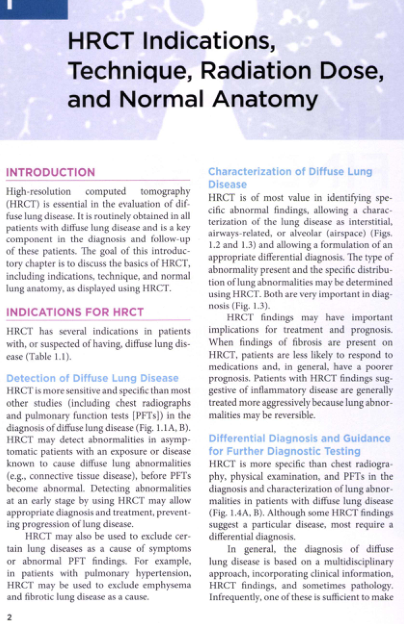

In [79]:
from PIL import Image
from io import BytesIO


def page_to_img(pg: fitz.Page, config=config):
    im: fitz.Pixmap = pg.get_pixmap(clip=config.get_cropbox(pg))
    bytes = im.tobytes("png")
    return Image.open(BytesIO(bytes))


# crop_page(pg)
page_to_img(pg)

In [52]:
def process_page(pg: fitz.Page):
    # page_to_img(pg).show()

    continuation = ""  # base text continuing from previous page's last entry
    mode = "startup"  # startup, header, body
    entries = []  # list of (header, text) tuples
    current_entry = ["", ""]  # current entry (header, text)
    done = False # whether we've reached the end of the chapter (e.x. sugguested readings section)

    flags = fitz.TEXTFLAGS_DICT & ~fitz.TEXT_PRESERVE_IMAGES & fitz.TEXT_DEHYPHENATE

    dict = pg.get_text("dict", flags=flags, clip=config.get_cropbox(pg))
    blocks = dict["blocks"]
    for block in blocks:
        for line in block["lines"]:
            for span in line["spans"]:
                txt = span["text"]

                if txt == 'SUGGESTED READING':
                    print('### Found end of chapter, stopping early ### ')
                    done = True
                    if mode == "body":
                        entries.append([ent.strip() for ent in current_entry])
                    return entries, continuation.strip(), done

                # if txt.endswith("-") and abs(w["x1"] - x1) < 0.08 * pg.width:

                font = (span["size"], span["font"])
                # print(font, txt)
                if font in config.font_ignore or span["font"] in config.font_ignore_names:
                    continue
                elif font in config.font_header:
                    match mode:
                        case "startup":
                            mode = "header"
                            current_entry = [txt, ""]
                        case "header":
                            current_entry[0] += txt
                        case "body":
                            mode = "header"
                            entries.append([ent.strip() for ent in current_entry])
                            current_entry = [txt, ""]
                elif font in config.font_body:
                    match mode:
                        case "startup":
                            if txt.endswith("."):
                                txt += "\n"
                            continuation += txt
                        case "header":
                            mode = "body"
                            current_entry[1] += txt
                        case "body":
                            if txt.endswith("."):
                                txt += "\n"
                            current_entry[1] += txt
                else:
                    if txt.strip():
                        print(f"Page {pg.number}: unknown font-pair {font}, ignoring text: '{txt}'")

    match mode:
        case "body":
            entries.append([ent.strip() for ent in current_entry])
        case "header", "startup":
            print("### Ended on", mode, "-- this should not happen")

    return entries, continuation.strip(), done


ent, cont, done = process_page(pg)


print('\n' + '='*80)
print("cont:", cont, "\n")
for h, b in ent:
    print("**", h, "**")
    print(b)
    print()


cont: Spiral or helical computed tomography (CT) allows the entire chest to be easily imaged during a single breath hold, with volumetric acquisition and exact registration or overlapping of slices. Two- and three-dimensional reformations may be performed if desired. Because scanning is rapid, contrast agents can be injected quickly, excellent vascular opacification can be achieved, and reduced volumes of contrast agent can be used. 

** SPIRAL CT IN CHEST DIAGNOSIS **
Multiple-detector CT (MDCT) scanners have multiple parallel rows (e.g., 64, 16, or 4) of x-ray detectors, although the number varies with the machine. Generally speaking, MDCT scanners with fewer rows (e.g., 16 or 4) are being replaced with scanners having more rows (e.g., 64), but this is an expensive and, therefore, gradual process.
With MDCT, each of the detector rows records data independently as the gantry rotates; consequently, a volume of the patient is imaged with each gantry rotation. For example, the detector 

In [53]:
from tqdm.notebook import tqdm
import csv


def process_file(fname: Path):
    config = Config(fname)
    chapters = config.chapter_range()
    # chapters = [config.chapter_range()[0]]
    for i, ch in enumerate(chapters, 1):
        pdf: fitz.Document = fitz.open(fname)
        pdf.select(range(*ch))
        print(f"Processing {i}:\t{ch[0]}-{ch[1]}")

        rows = ['header','body']
        ch_entries = [rows]
        
        for pg in pdf:
            entries, cont, done = process_page(pg)

            if cont:
                if ch_entries and ch_entries[-1] != rows:
                    ch_entries[-1][1] = ch_entries[-1][1] + cont
                else:
                    ch_entries.append(["Chapter Introduction", cont])

            ch_entries += entries 

            if done:
                break

        outdir = Path("scrape_out")
        outdir.mkdir(exist_ok=True)
        with open(outdir / f"{fname.stem}_ch{i}.csv", "w") as f:
            writer = csv.writer(f)
            writer.writerows(ch_entries)

            print(f"Saved to {f.name}")
        

process_file(fname)

Processing 1:	6-12
### Found end of chapter, stopping early ### 
Saved to scrape_out/Chest - Webb - Fundamentals of Body CT (4e)_ch1.csv
Processing 2:	12-26
### Found end of chapter, stopping early ### 
Saved to scrape_out/Chest - Webb - Fundamentals of Body CT (4e)_ch2.csv
Processing 3:	26-49
### Found end of chapter, stopping early ### 
Saved to scrape_out/Chest - Webb - Fundamentals of Body CT (4e)_ch3.csv
Processing 4:	49-73
Page 7: unknown font-pair (8.0, 'TnQ'), ignoring text: '≤'
Page 7: unknown font-pair (8.0, 'TnQ'), ignoring text: '≤'
Page 7: unknown font-pair (8.0, 'TnQ'), ignoring text: '≤'
Page 7: unknown font-pair (8.0, 'TnQ'), ignoring text: '≤'
Page 7: unknown font-pair (8.0, 'TnQ'), ignoring text: '≤'
Page 7: unknown font-pair (8.0, 'TnQ'), ignoring text: '≥'
### Found end of chapter, stopping early ### 
Saved to scrape_out/Chest - Webb - Fundamentals of Body CT (4e)_ch4.csv
Processing 5:	73-94
### Found end of chapter, stopping early ### 
Saved to scrape_out/Chest - W

# old (unused) code

In [124]:
import re
from pdfplumber.page import Page
from collections import deque


def process_page(pg: Page):
    assert not isinstance(pg, pdfplumber.page.CroppedPage)
    assert pg.textboxhorizontals, "Pass `laparams={...}` when opening the PDF file"

    if (pg.page_number % 2) and config["odd_spread"]:
        crop_box = (
            config["crop_outer"],
            config["crop_top"],
            pg.width - config["crop_inner"],
            pg.height - config["crop_bot"],
        )
    else:
        crop_box = (
            config["crop_inner"],
            config["crop_top"],
            pg.width - config["crop_outer"],
            pg.height - config["crop_bot"],
        )

    pg_crop = pg.within_bbox(crop_box)
    # pg.to_image(resolution=123).draw_rects(pg_crop.textboxhorizontals).show()
    # pg.to_image(resolution=123).draw_rects(pg_crop.extract_words()).show()

    continuation = ""  # base text continuing from previous page's last entry
    mode = "startup"  # startup, header, body
    entries = []  # list of (header, text) tuples
    current_entry = ["", ""]  # current entry (header, text)

    """
    0. We add all non-header text to continuation
    1. When header char is found, we look until we find the next non-header char
    2. Then we keep going until we find the next header char, and go back to (1)
    """

    last_y = float("inf")

    # todo can I pass args s.t. this correctly parses two columns; or figure out how to order via x0/x1
    for i, box in enumerate(pg_crop.textboxhorizontals):  # [26:27]
        # text = box['text']
        # text = re.sub(r'\n', ' ', text)
        # text = re.sub(r'\s+', ' ', text)
        # words = text.split()
        # print(words)
        # if len(words) < 4: continue

        x0, y0, x1, y1 = box["x0"], box["y0"], box["x1"], box["y1"]
        bbox = (x0, pg.height - y1, x1, pg.height - y0)  # = (x0, y0, x1, y1)
        pg_bbox = pg.crop(bbox, relative=True)

        if mode == "body" and not (
            abs(y1 - last_y) > 0.8 * pg.height
        ):  # condition of text continuation across columns
            current_entry[1] += "\n"

        last_y = y0

        chars = deque(
            [
                c
                for c in pg_bbox.chars
                if c["fontname"] not in config["font_ignore_names"]
            ]
        )
        # print([c for c in pg_bbox.chars if c['fontname'] in config["font_ignore_names"]])
        words = pg_bbox.extract_words()

        # pg_bbox.to_image(resolution=150).draw_rects(chars).show()

        for w in words:
            # ! TODO Find a better way to do this
            try:
                while not w["text"][0].startswith(chars[0]["text"]):
                    # print(w["text"], chars[0]["text"])
                    chars.popleft()

                # if chars:
                #     chars.popleft()
            except IndexError as e:
                #  "".join([w["text"] for w in words])
                print(f"Box {i}: Could not parse the box of text: {e}")
                print(" ".join([w["text"] for w in words]))
                print("".join([c["text"] for c in pg_bbox.chars]))
                break

            txt = w["text"].strip()
            if txt.endswith("-") and abs(w["x1"] - x1) < 0.08 * pg.width:
                txt = txt[:-1]
            else:
                txt = txt + " "

            fname = chars[0]["fontname"]
            if fname in config["font_header_names"]:
                match mode:
                    case "startup":
                        mode = "header"
                        current_entry = [txt, ""]
                    case "header":
                        current_entry[0] += txt
                    case "body":
                        mode = "header"
                        entries.append([ent.strip() for ent in current_entry])
                        current_entry = [txt, ""]
            elif fname in config["font_body_names"]:
                match mode:
                    case "startup":
                        continuation += txt
                    case "header":
                        mode = "body"
                        current_entry[1] += txt
                    case "body":
                        current_entry[1] += txt
            elif fname in config["font_ignore_names"]:
                continue
            else:
                print(f"Unknown font {fname}: '{txt}'")
                # pg_bbox.to_image(resolution=123).draw_rects(chars).show()

        # pg_bbox.to_image(resolution=150).show()
        # pg_bbox.to_image(resolution=150).draw_rects(chars).show()

    return entries, continuation


ent, cont = process_page(pg)
print("cont:", cont, "\n")
for h, b in ent:
    print("**", h, "**")
    print(b)
    print()

Box 3: Could not parse the box of text: deque index out of range
Scanning is begun when the vessels of interest are opacified. For pulmonary embolism diagno- sis, the pulmonary arteries need to be opacified; this usually requires a 10- to 15-second delay, although timing the scan to the aorta or left atrium may be beneficial. For diagnosis of aortic abnormalities, a delay of 20 to 30 seconds is usu- ally needed. The delay varies in individual patients according to a number of factors. Tim- ing the scan delay is usually done using a timing bolus or software available on the scanner, which shows vascular opacification during the injection and begins scanning when contrast appears in the target vessel. The use of an oral contrast agent for opacification of the esophagus and gastrointesti- nal tract is not necessary unless a specific gastro- intestinal (i.e., esophageal) abnormality is suspected.
Scanning is begun when the vessels of interest are opacified. For pulmonary embolism diagno-si